In [384]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

from sklearn import neighbors

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler



# EDA Validierung des Datensatzes

In [385]:
diabetes = pd.read_csv("diabetes.csv")

In [386]:
diabetes.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [387]:
diabetes.shape

(768, 9)

In [388]:
diabetes.duplicated().sum()

0

In [389]:
diabetes.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [390]:
diabetes.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [391]:
diabetes[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = diabetes[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)
diabetes.describe()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,763.000000,733.000000,541.000000,394.000000,757.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.153420,155.548223,32.457464,0.471876,33.240885,0.348958
std,3.369578,30.535641,12.382158,10.476982,118.775855,6.924988,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,22.000000,76.250000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,141.000000,80.000000,36.000000,190.000000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [392]:
diabetes["Outcome"].value_counts(0)

Outcome
0    500
1    268
Name: count, dtype: int64

## Aufbereitung der fehlenden Daten

### Insulin

In [393]:
H = diabetes[diabetes['Outcome'] == 0]
D = diabetes[diabetes['Outcome'] == 1]

sample_size = 250

# Bootstrapping-Verfahren für gesunde Personen
H_sample = H.sample(n=sample_size, replace=True, random_state=42)

# Bootstrapping-Verfahren für nicht gesunde Personen
D_sample = D.sample(n=sample_size, replace=True, random_state=42)

diabetes = pd.concat([H_sample, D_sample])

In [394]:
def median_target(var):
    temp = diabetes[diabetes[var].notnull()]
    temp = temp[[var, 'Outcome']].groupby(['Outcome'])[[var]].median().reset_index()
    return temp

def change_value(var):
    diabetes.loc[(diabetes['Outcome'] == 0 ) & (diabetes[var].isnull()), var] = median_target(var)[var][0]
    diabetes.loc[(diabetes['Outcome'] == 1 ) & (diabetes[var].isnull()), var] = median_target(var)[var][1]

Text(0.5, 0, 'Insulin μU/ml')

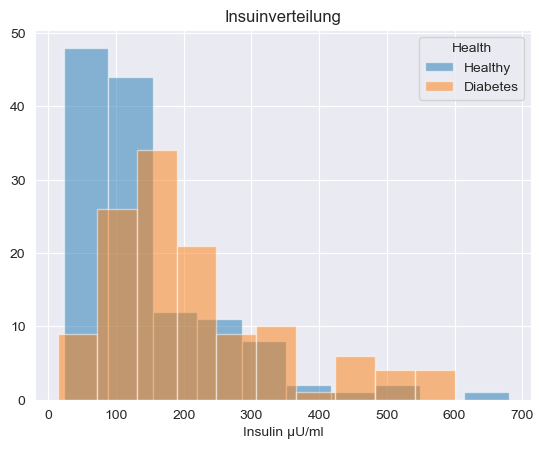

In [395]:
H = diabetes.loc[diabetes["Outcome"] == 0, "Insulin"]
D = diabetes.loc[diabetes["Outcome"] == 1, "Insulin"]

plt.hist(H, alpha=0.5, label='Healthy')
plt.hist(D, alpha=0.5, label='Diabetes')
plt.legend(title='Health')
plt.title("Insuinverteilung")
plt.xlabel("Insulin μU/ml")

In [396]:
change_value("Insulin")

### Glucose

Text(0.5, 0, 'Glucosekonzentration')

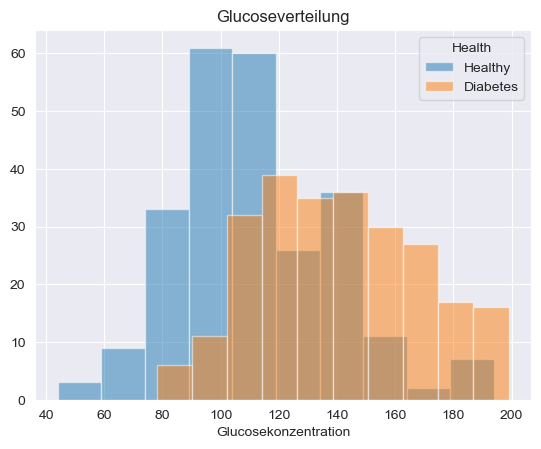

In [397]:
H = diabetes.loc[diabetes["Outcome"] == 0, "Glucose"]
D = diabetes.loc[diabetes["Outcome"] == 1, "Glucose"]
plt.hist(H, alpha=0.5, label='Healthy')
plt.hist(D, alpha=0.5, label='Diabetes')
plt.legend(title='Health')
plt.title("Glucoseverteilung")
plt.xlabel("Glucosekonzentration")

In [398]:
change_value("Glucose")

### SkinThickness

,Outcome,SkinThickness
0,0,25.0
1,1,32.0


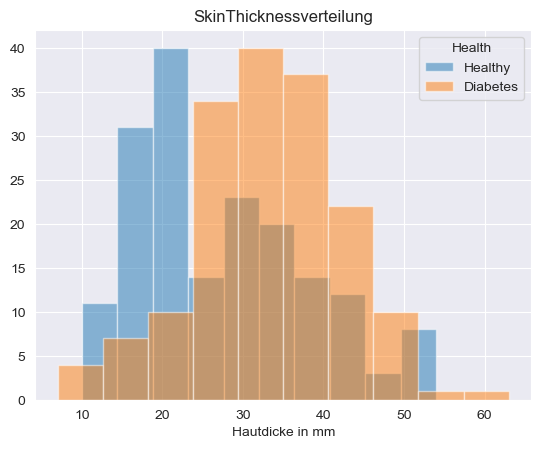

In [399]:
H = diabetes.loc[diabetes["Outcome"] == 0, "SkinThickness"]
D = diabetes.loc[diabetes["Outcome"] == 1, "SkinThickness"]
plt.hist(H, alpha=0.5, label='Healthy')
plt.hist(D, alpha=0.5, label='Diabetes')
plt.legend(title='Health')
plt.title("SkinThicknessverteilung")
plt.xlabel("Hautdicke in mm")
median_target('SkinThickness')

In [400]:
change_value("SkinThickness")

### Blood Pressure

,Outcome,BloodPressure
0,0,70.0
1,1,74.0


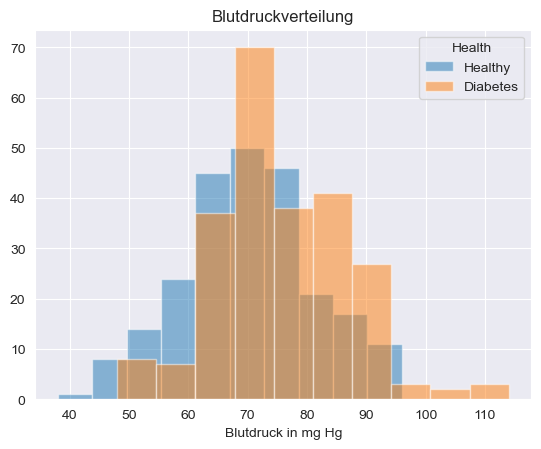

In [401]:
H = diabetes.loc[diabetes["Outcome"] == 0, "BloodPressure"]
D = diabetes.loc[diabetes["Outcome"] == 1, "BloodPressure"]
plt.hist(H, alpha=0.5, label='Healthy')
plt.hist(D, alpha=0.5, label='Diabetes')
plt.legend(title='Health')
plt.title("Blutdruckverteilung")
plt.xlabel("Blutdruck in mg Hg")
median_target("BloodPressure")

In [402]:
change_value("BloodPressure")

### BMI

,Outcome,BMI
0,0,29.3
1,1,34.0


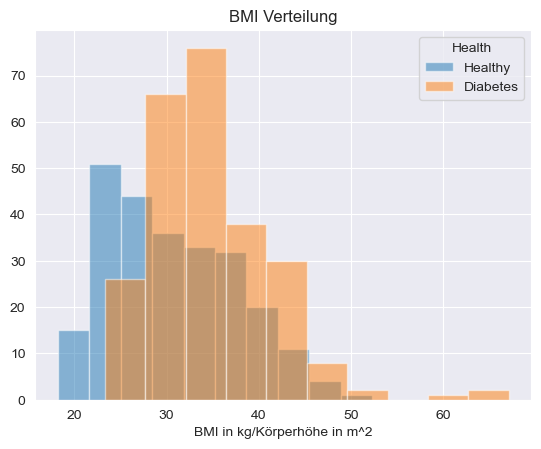

In [403]:
H = diabetes.loc[diabetes["Outcome"] == 0, "BMI"]
D = diabetes.loc[diabetes["Outcome"] == 1, "BMI"]
plt.hist(H, alpha=0.5, label='Healthy')
plt.hist(D, alpha=0.5, label='Diabetes')
plt.legend(title='Health')
plt.title("BMI Verteilung")
plt.xlabel("BMI in kg/Körperhöhe in m^2")
median_target("BMI")

In [404]:
change_value("BMI")

## Multivariante Analyse

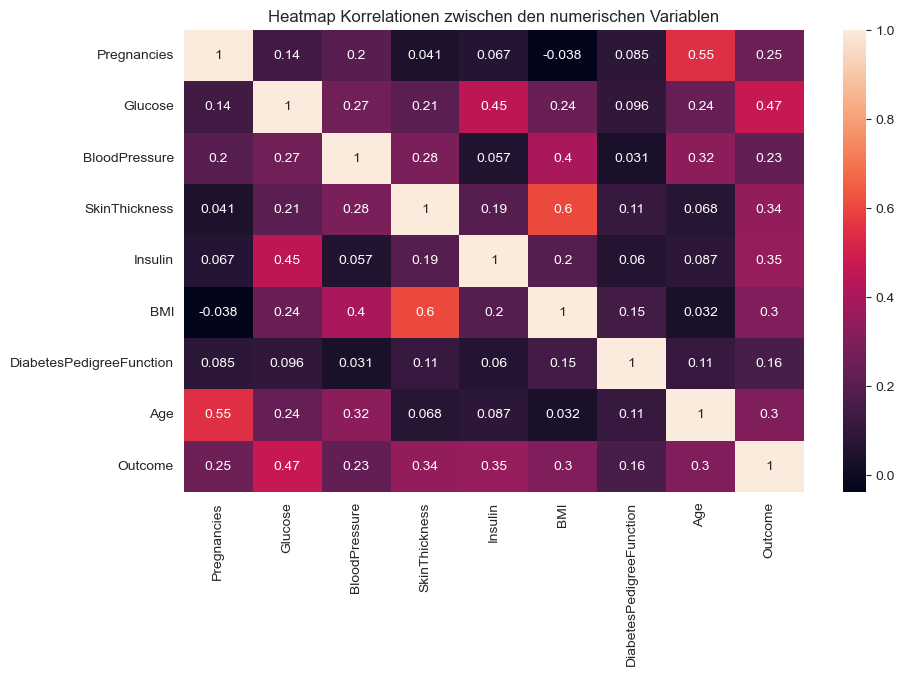

In [405]:
fig_dims = (10, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.heatmap(diabetes.corr(),annot=True,ax=ax)
plt.title("Heatmap Korrelationen zwischen den numerischen Variablen",fontsize=12)
plt.show()

## ZUSAMMEN FASSUNG EDA TODO
- 
- fdg
- dfg
- dg
- 

# Modellierung

### Logistic Regression

In [407]:
x = diabetes.drop(columns=['Outcome'], axis=1)
y = diabetes['Outcome']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=43)

In [408]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [409]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
# Vorhersage für Testdaten
y_pred_lr = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.7733333333333333


### Evaluation des Models

In [410]:
cflr = confusion_matrix(y_test,y_pred_lr)
pd.crosstab(y_test, y_pred_lr, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,56,18,74
1,16,60,76
All,72,78,150


**Classification Report**

1. Precision (Präzision):
Der Anteil der wahren positiven Vorhersagen unter allen positiven Vorhersagen.
Precision = TP / (TP + FP)

2. Recall (Rückruf):
Der Anteil der wahren positiven Vorhersagen unter allen tatsächlichen positiven Instanzen.
Recall = TP / (TP + FN)

3. F1-Score:
Das harmonische Mittel aus Precision und Recall.
F1-Score = 2 * (Precision * Recall) / (Precision + Recall)

4. Support:
Die Anzahl der tatsächlichen Instanzen für jede Klasse.

5. Accuracy (Genauigkeit):
Der Anteil der korrekten Vorhersagen insgesamt.
Accuracy = (TP + TN) / (TP + TN + FP + FN)

6. Macro AVG (Makro-Durchschnitt):
Der Durchschnitt der Metriken für jede Klasse, ohne dabei die Klassenhäufigkeiten zu berücksichtigen.

7. Weighted AVG (Gewichteter Durchschnitt):
Der gewichtete Durchschnitt der Metriken für jede Klasse, wobei die Klassenhäufigkeiten berücksichtigt werden.

In [411]:
print(classification_report(y_test,y_pred_lr))

              precision    recall  f1-score   support

           0       0.78      0.76      0.77        74
           1       0.77      0.79      0.78        76

    accuracy                           0.77       150
   macro avg       0.77      0.77      0.77       150
weighted avg       0.77      0.77      0.77       150


**AUC-ROC (Area Under the ROC Curve):** Die Fläche unter der ROC-Kurve. Eine AUC von 1,0 bedeutet perfekte Vorhersagen, während eine AUC von 0,5 auf eine zufällige Vorhersage hinweist.

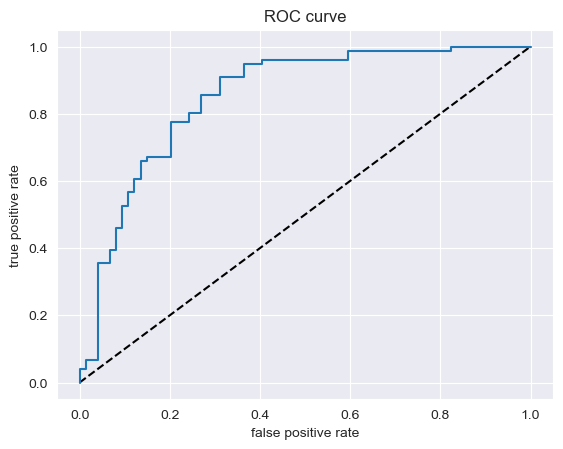

In [412]:
y_pred_proba = logreg.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='Logistic Regression')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('ROC curve')
plt.show()

In [413]:
print("ROC Accuracy: {}".format(roc_auc_score(y_test,y_pred_proba)))

ROC Accuracy: 0.8509957325746799


## Random Forrest

In [414]:
model = RandomForestClassifier(n_estimators=20, criterion = 'gini', bootstrap = True, random_state=100)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=20, random_state=100)

In [415]:
y_pred_rf = model.predict(X_test)

In [416]:
cfrf=confusion_matrix(y_test,y_pred_rf)
pd.crosstab(y_test, y_pred_rf, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,69,5,74
1,6,70,76
All,75,75,150


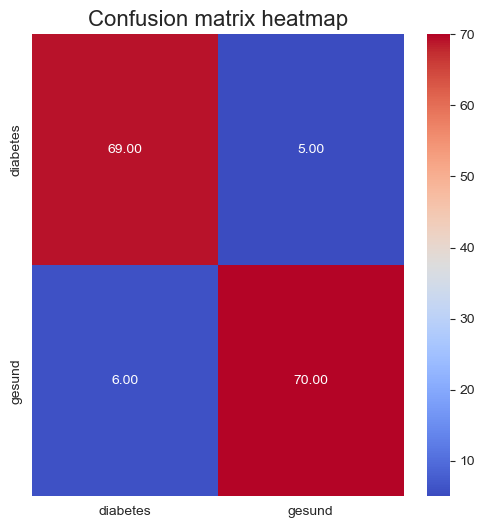

In [417]:
plt.figure(figsize=(6, 6))
x_axis_labels = ['diabetes', 'gesund'] # labels for x-axis
y_axis_labels = ['diabetes', 'gesund'] # labels for y-axis
sns.heatmap(cfrf, annot=True, xticklabels=x_axis_labels, yticklabels=y_axis_labels, fmt=".2f", cmap='coolwarm')
plt.title("Confusion matrix heatmap", fontsize=16)
plt.show()

In [418]:
print(classification_report(y_test,y_pred_rf))

              precision    recall  f1-score   support

           0       0.92      0.93      0.93        74
           1       0.93      0.92      0.93        76

    accuracy                           0.93       150
   macro avg       0.93      0.93      0.93       150
weighted avg       0.93      0.93      0.93       150


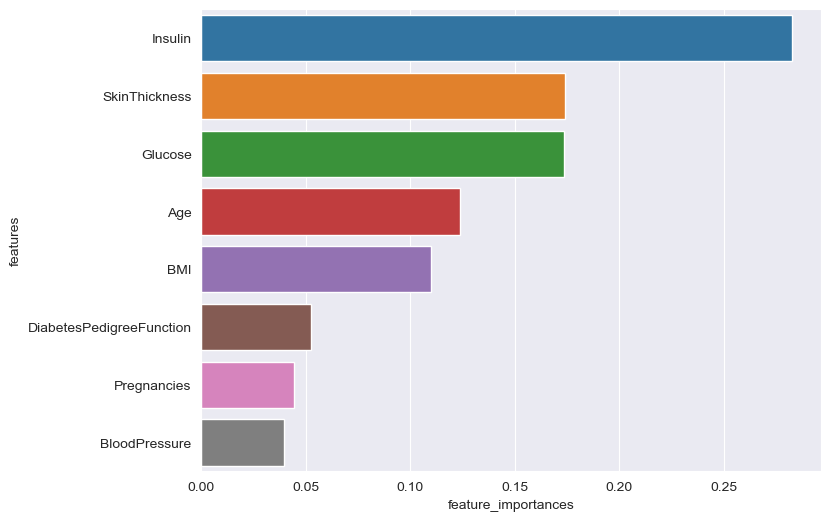

In [419]:
fi_df = pd.DataFrame({
    "feature_importances" : model.feature_importances_,
    "features" : x.columns
})

fi_df.sort_values(by="feature_importances", ascending=False, inplace=True)

plt.figure(figsize=(8,6))
sns.barplot(x="feature_importances", y="features", data=fi_df)
plt.show()

## kNN

In [420]:
weights = 'distance'
n_neighbors = 9
clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
clf.fit(X_train, y_train)


KNeighborsClassifier(n_neighbors=9, weights='distance')

In [421]:
y_pred_knn = clf.predict(X_test)

cfknn=confusion_matrix(y_test,y_pred_knn)
pd.crosstab(y_test, y_pred_knn, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,61,13,74
1,3,73,76
All,64,86,150


In [422]:
print(classification_report(y_test,y_pred_knn))

              precision    recall  f1-score   support

           0       0.95      0.82      0.88        74
           1       0.85      0.96      0.90        76

    accuracy                           0.89       150
   macro avg       0.90      0.89      0.89       150
weighted avg       0.90      0.89      0.89       150


## VERGLEICH DER MODELLE

Text(4, 90, '\nRealität: 152 Gesund, \n79 Krank\n')

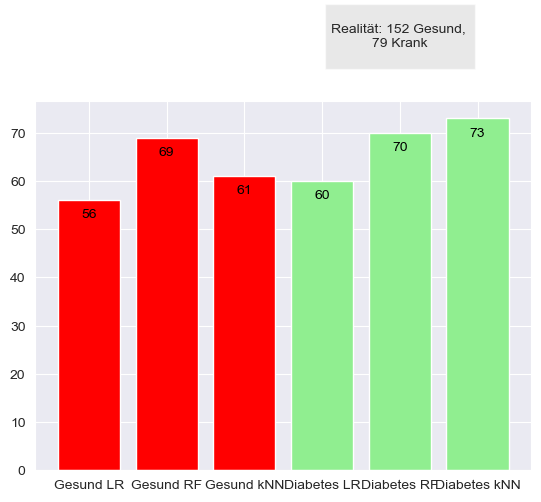

In [423]:
recall_LR = cflr[0,0]
recall_RF = cfrf[0,0]
recall_kNN = cfknn[0,0]
precision_LR = cflr[1,1]
precision_RF = cfrf[1,1]
precision_kNN = cfknn[1,1]

werte = [recall_LR, recall_RF, recall_kNN,precision_LR, precision_RF,precision_kNN]
farben = ['red', 'red', 'red',  'lightgreen', 'lightgreen','lightgreen']
bars = plt.bar(range(len(werte)), werte, color = farben)

kategorien = ['Gesund LR', 'Gesund RF','Gesund kNN', 'Diabetes LR','Diabetes RF', 'Diabetes kNN']
plt.xticks(range(len(werte)), kategorien)

for bar, wert in zip(bars, werte):
    plt.annotate(str(wert), xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()), xytext=(0, -15),
             textcoords='offset points', ha='center', va='bottom', color='black')

textblock = '''
Realität: 152 Gesund, 
79 Krank
'''

plt.text(4, 90, textblock, ha='center', va='center', bbox=dict(facecolor='lightgray', alpha=0.5))